In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import numpy as np
import random
import copy

## Loading Text File

In [7]:
filename = "/content/dataset.txt"
all_text = open(filename, 'r', encoding='utf-8').read().lower()
print('Num Of Chars:', len(all_text))
print('____________________ \n')
print(all_text[0:150])

Num Of Chars: 1107542
____________________ 

harry potter and the goblet of fire

chapter one - the riddle house

	the villagers of little hangleron still called it "the riddle house," even thoug


## Preprocessing

In [8]:
#In first step text was converted to a lower case
#removing numbers
all_text = ''.join(c for c in all_text if not c.isdigit())

#removing non alphabetic chars
values = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ")
values.append('\n')
def remove_non_alpha(my_string = ""):
  for item in my_string:
    if item not in values:
      my_string = my_string.replace(item, "")
  return my_string

all_text = remove_non_alpha(all_text)

In [9]:
chars = sorted(list(set(all_text)))
print('Num of chars in a text:', len(all_text))
print('Num of char types in a text:', len(chars))

Num of chars in a text: 1050393
Num of char types in a text: 28


In [79]:
#dictionary of chars mapped to int
char_to_int_dict = dict((c, i) for i, c in enumerate(chars))
print('Char to int dict:\n',char_to_int_dict)
#dictionary of int mapped to chars
int_to_char_dict = dict((i, c) for i, c in enumerate(chars))
print('Int to char dict:\n',int_to_char_dict)

Char to int dict:
 {'\n': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}
Int to char dict:
 {0: '\n', 1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z'}


## Doing the Basics of Algorithm

In [11]:
seq_length = 65
jump = 10
sentences = []
next_chars = []
for i in range(0, len(all_text) - seq_length, jump):
  sentences.append(all_text[i: i + seq_length])
  next_chars.append(all_text[i + seq_length])
print('for example:\n\n', sentences[0], '\n\nwe have to predict:', next_chars[0])

for example:

 harry potter and the goblet of fire

chapter one  the riddle hous 

we have to predict: e


In [12]:
x = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i, t, char_to_int_dict[char]] = True
  y[i, char_to_int_dict[next_chars[i]]] = True

print('x shape:', x.shape)
print('y shape:', y.shape)
print('x[0]:\n', x[0])
print('y[0]:\n', y[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


x shape: (105033, 65, 28)
y shape: (105033, 28)
x[0]:
 [[False False False ... False False False]
 [False False  True ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
y[0]:
 [False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False]


## Creating the Model

In [73]:
#Two LSTM layer used
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, len(chars)), return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dropout(0.25))
model.add(Dense(len(chars), activation = 'softmax'))

my_optimizer = RMSprop(lr = 0.01)
# my_optimizer = 'adam'
# my_optimizer = 'SGD'

# my_loss = 'categorical_crossentropy'
my_loss = "binary_crossentropy"
# my_loss = "kl_divergence"

model.compile(loss = my_loss, optimizer = my_optimizer, metrics = ['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 65, 64)            23808     
                                                                 
 dropout_20 (Dropout)        (None, 65, 64)            0         
                                                                 
 lstm_22 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 28)                1820      
                                                                 
Total params: 58,652
Trainable params: 58,652
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Fitting the Model

In [74]:
history = model.fit(x, y, batch_size = 128, epochs = 60, validation_split = 0.15)

Epoch 1/60
698/698 [==============================] - 12s 14ms/step - loss: 0.1214 - accuracy: 0.2955 - val_loss: 0.1016 - val_accuracy: 0.3992
Epoch 2/60
698/698 [==============================] - 9s 12ms/step - loss: 0.1021 - accuracy: 0.4062 - val_loss: 0.0933 - val_accuracy: 0.4411
Epoch 3/60
698/698 [==============================] - 9s 12ms/step - loss: 0.0964 - accuracy: 0.4404 - val_loss: 0.0894 - val_accuracy: 0.4625
Epoch 4/60
698/698 [==============================] - 9s 12ms/step - loss: 0.0933 - accuracy: 0.4588 - val_loss: 0.0880 - val_accuracy: 0.4708
Epoch 5/60
698/698 [==============================] - 9s 12ms/step - loss: 0.0912 - accuracy: 0.4711 - val_loss: 0.0857 - val_accuracy: 0.4904
Epoch 6/60
698/698 [==============================] - 9s 12ms/step - loss: 0.0898 - accuracy: 0.4799 - val_loss: 0.0846 - val_accuracy: 0.4948
Epoch 7/60
698/698 [==============================] - 9s 12ms/step - loss: 0.0885 - accuracy: 0.4865 - val_loss: 0.0838 - val_accuracy: 0.497

## Results

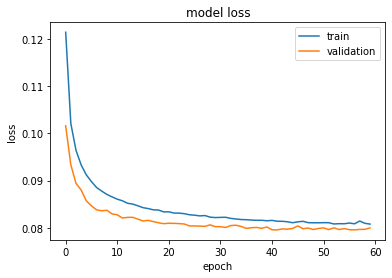

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

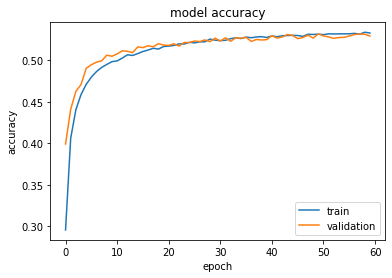

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## Generating Text

In [85]:
def find_next_char(preds):
  preds = np.asarray(preds).astype('float64')
  preds_ = np.exp(np.log(preds))
  return int_to_char_dict[np.argmax(np.random.multinomial(1, preds_ / np.sum(preds_), 1))]

start_index = random.randint(0, len(all_text) - 300)
sentence = all_text[start_index: start_index + seq_length]
generated = ''
initial_sentence = copy.deepcopy(sentence)

for i in range(200):
  x_pred = np.zeros((1, seq_length, len(chars)))
  for t, char in enumerate(sentence):
    x_pred[0, t, char_to_int_dict[char]] = True
  preds = model.predict(x_pred)[0]
  next_char = find_next_char(preds)
  generated += next_char
  sentence = sentence[1:] + next_char

print('\nInitial Sentence:\n', initial_sentence,'\n')
print('Generated after initial sentence:\n','...', generated)


Initial Sentence:
  of rotting fish  every now and then sparks would fly out of the  

Generated after initial sentence:
 ... wame of donist get they was abaut what their the poened hagrid  got magic of the toppord at theard ingennoffots he and himseln stairs and wordly as frether a peblight of the look  you they had because
